# PUDIDI Optimizer — Short-Term Hydro Operations with Market Prices

This notebook formulates a short-term hydro optimization (“PUDIDI Optimizer”) where the objective is driven by hourly market prices. You can solve for an optimal operation schedule (e.g., turbine discharge / generation) subject to plant and storage constraints.

**What you’ll find here**
- A clear problem statement and model assumptions (single plant, hourly step, finite horizon).
- Inputs: technical limits, initial storage, and **hourly prices pulled directly from the Coordinador Eléctrico** (CMG Programado PCP) for the selected node.
- Outputs: an economically optimal operation plan and its implied revenues.

> Tip: After you change the date range or the CMG node, re-run the “Price data from Coordinador API” cell before solving to keep the model in sync with the latest prices.


In [1]:
# pip install pyomo highspy
from typing import Sequence, Dict
import math
from pyomo.environ import (
    ConcreteModel, RangeSet, Param, Var, Expression, Constraint, Objective,
    maximize, SolverFactory, value
)
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd

In [ ]:

def build_hydro_lp(
    price: Sequence[float],     # π_t  [$ / MWh], length T
    inflow: Sequence[float],    # I_t  [m^3/s],   length T
    dt_hours: float,            # Δt  [hours]
    kappa: float,               # Q = kappa * P,  [m^3/s per MW]
    P_min: float,               # [MW]
    P_max: float,               # [MW]
    S0: float,                  # initial storage [m^3]
    S_min: float,               # [m^3]
    S_max: float,               # [m^3]
):
    """
    Build the simplified LP:
      max   sum_t π_t * P_t * Δt
      s.t.  P_min <= P_t <= P_max
            S_min <= S0 + sum_{τ<=t} (I_τ - Q_τ) * 3600*Δt <= S_max   ∀ t
            Q_t = kappa * P_t
    No spill, no ramps, no scenarios.
    """
    T = len(price)
    assert len(inflow) == T, "price and inflow must have same length"
    assert P_min <= P_max
    assert S_min <= S0 <= S_max

    m = ConcreteModel(name="HydroDispatchLP")
    m.T = RangeSet(0, T - 1)

    # Parameters
    m.dt = Param(initialize=float(dt_hours))
    m.vol = Param(initialize=3600.0 * float(dt_hours))   # seconds per step
    m.kappa = Param(initialize=float(kappa))
    m.P_min = Param(initialize=float(P_min))
    m.P_max = Param(initialize=float(P_max))
    m.S0    = Param(initialize=float(S0))
    m.S_min = Param(initialize=float(S_min))
    m.S_max = Param(initialize=float(S_max))

    m.price = Param(m.T, initialize=lambda _, t: float(price[t]))
    m.I     = Param(m.T, initialize=lambda _, t: float(inflow[t]))

    # Decision variable: P_t only (bounds handle P_min/P_max)
    m.P = Var(m.T, bounds=lambda m, t: (m.P_min, m.P_max))

    # Derived turbined flow: Q_t = kappa * P_t   [m^3/s]
    m.Q = Expression(m.T, rule=lambda m, t: m.kappa * m.P[t])

    # Cumulative storage at each prefix t (Expression)
    # S_cum[t] = S0 + sum_{τ=0..t} (I_τ - Q_τ) * vol
    def S_cum_rule(m, t):
        return m.S0 + sum((m.I[tau] - m.Q[tau]) * m.vol for tau in range(0, t + 1))
    m.S_cum = Expression(m.T, rule=S_cum_rule)

    # Storage bounds must hold at every t
    m.StorageLower = Constraint(m.T, rule=lambda m, t: m.S_min <= m.S_cum[t])
    m.StorageUpper = Constraint(m.T, rule=lambda m, t: m.S_cum[t] <= m.S_max)

    # Objective: maximize revenue
    m.Revenue = Objective(expr=sum(m.price[t] * m.P[t] * m.dt for t in m.T), sense=maximize)

    return m

def solve_model(model, solver_preference=("highs", "glpk", "cbc"), tee: bool=False):
    """
    Solve with the first available solver in solver_preference.
    """
    for name in solver_preference:
        try:
            opt = SolverFactory(name)
            if opt.available():
                res = opt.solve(model, tee=tee)
                return name, res
        except Exception:
            continue
    raise RuntimeError("No suitable LP solver found. Install 'highspy' (HiGHS) or GLPK/CBC.")

def extract_solution(model) -> Dict[str, list]:
    """
    Returns dict with P (MW), Q (m^3/s), and S (m^3) time series.
    """
    T = len(model.T)
    P = [value(model.P[t]) for t in model.T]
    Q = [value(model.Q[t]) for t in model.T]
    S = [value(model.S_cum[t]) for t in model.T]  # storage at end of each step
    return {"P": P, "Q": Q, "S": S}


In [ ]:
url = "https://sipub.api.coordinador.cl:443/cmg-programado-pid/v4/findByDate"
params = {
    "startDate": "2025-08-22",
    "endDate": "2025-08-22",
    "page": 1,
    "limit": 100000,
    "user_key": "bae940cb90ef4111ffacb6baa9806fc0"
}
response = requests.get(url, params=params)
data = response.json()
df = pd.DataFrame(data['data'])
df=df.loc[df['llave_cmg'].isin(['Pid-Pid110'])]
precio = (
    df.sort_values('hora_programa')
      .groupby('fecha_hora')
      .tail(1)
      .sort_values('fecha_hora')
      ['cmg_usd_mwh']
      .tolist()
)
precio

[78.1920119937053,
 76.0515368744597,
 79.2673750875966,
 84.3833203291406,
 84.712994126531,
 83.7399092468751,
 72.4163657485493,
 131.202561781942,
 133.621479505764,
 137.361888031812,
 133.957802715983,
 133.561518638131,
 133.67458638455,
 133.807115905992,
 137.643149375621,
 134.862004362503,
 128.869554035492,
 119.943335637949]

Solver: highs
P[0:6] (MW): [0.5, 0.5, 0.5, 1.2, 3.0, 0.5]
Q[0:6] (m3/s): [0.333, 0.333, 0.333, 0.8, 2.0, 0.333]
S[0:6] (m3): [27760, 30520, 33280, 34360, 31120, 33880]


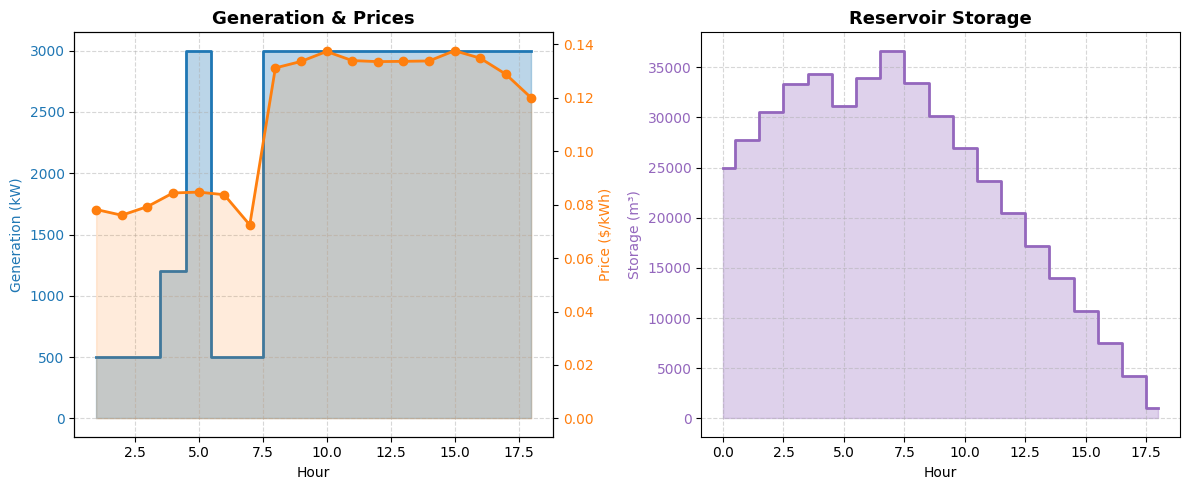

In [ ]:
# ---------- Example usage (manual prices + plots) ----------
if __name__ == "__main__":

    # --- 1) PRICES ($/MWh) ---
    price=precio
    T = len(price)

    # --- 2) INPUTS
    dt = 1.0                         # hours per step
    inflow = [1.1] * T               # m^3/s (set your forecast if any)
    kappa = 2/3                     # Q = kappa * P  [m^3/s per MW]
    P_min, P_max = 0.5,3       # MW
    S0, S_min, S_max = 25_000, 1_000, 50_000  # m^3

    # --- 3) Build, solve, extract ---
    model = build_hydro_lp(
        price=price, inflow=inflow, dt_hours=dt, kappa=kappa,
        P_min=P_min, P_max=P_max, S0=S0, S_min=S_min, S_max=S_max
    )
    solver_used, results = solve_model(model, solver_preference=("highs", "glpk", "cbc"), tee=False)
    sol = extract_solution(model)  # dict: P (MW), Q (m3/s), S (m3) at end of each step

    print(f"Solver: {solver_used}")
    print("P[0:6] (MW):", [round(x, 2) for x in sol["P"][:6]])
    print("Q[0:6] (m3/s):", [round(x, 3) for x in sol["Q"][:6]])
    print("S[0:6] (m3):", [round(x) for x in sol["S"][:6]])

    # --- 4) Plots ---
    def plot_hydro_results(prices_MWh, P_MW, S_end_m3, S0, dt_hours=1.0):
        T = len(P_MW)
        hours_gen = np.arange(1, T + 1)
        hours_sto = np.arange(0, T + 1)

        p_kW = np.asarray(P_MW) * 1000.0
        price_kWh = np.asarray(prices_MWh) / 1000.0   # $/kWh from $/MWh
        stor = np.concatenate(([S0], np.asarray(S_end_m3)))

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # --- Plot 1: Generation & Prices ---
        ax1 = axes[0]
        color_gen = "#1f77b4"
        color_price = "#ff7f0e"
        ax1.fill_between(hours_gen, p_kW, alpha=0.30, step="mid", color=color_gen)
        ax1.step(hours_gen, p_kW, where="mid", linewidth=2, color=color_gen, label="Generation (kW)")
        ax1.set_xlabel("Hour")
        ax1.set_ylabel("Generation (kW)", color=color_gen)
        ax1.tick_params(axis='y', labelcolor=color_gen)

        ax2 = ax1.twinx()
        ax2.fill_between(hours_gen, price_kWh[:T], alpha=0.15, color=color_price)
        ax2.plot(hours_gen, price_kWh[:T], linewidth=2, marker="o", color=color_price, label="Price ($/kWh)")
        ax2.set_ylabel("Price ($/kWh)", color=color_price)
        ax2.tick_params(axis='y', labelcolor=color_price)

        ax1.set_title("Generation & Prices", fontsize=13, weight="bold")

        # --- Plot 2: Storage ---
        ax3 = axes[1]
        color_storage = "#9467bd"
        ax3.fill_between(hours_sto, stor, alpha=0.30, step="mid", color=color_storage)
        ax3.step(hours_sto, stor, where="mid", linewidth=2, color=color_storage, label="Storage (m³)")
        ax3.set_xlabel("Hour")
        ax3.set_ylabel("Storage (m³)", color=color_storage)
        ax3.tick_params(axis='y', labelcolor=color_storage)
        ax3.set_title("Reservoir Storage", fontsize=13, weight="bold")

        for ax in (ax1, ax3):
            ax.grid(True, linestyle="--", alpha=0.5)
        fig.tight_layout()
        plt.show()

    plot_hydro_results(price, sol["P"], sol["S"], S0, dt_hours=dt)

In [ ]:
price = [114,
 127,
 144,
 118,
 125,
 108,
 109,
 107,
 86,
 57,
 76,
 112,
 119,
 98,
 90,
 83,
 107,
 124,
 125,
 77,
 50,
 38,
 43,
 58,
 66,
 75,
 92,
 90,
 65,
 85,
 10,
 130,
 150,
 120,
 100,
 85,
 70,
 55,
 45,
 40,
 120,
 100,
 85,
 70,
 55,
 45,
 40]

## Annex: Problem Model

## Objective (maximize revenue)

$$
\max \ \sum_{t=0}^{T-1} \pi_t\,P_t\,\Delta t
$$

## Decision variables

* $P_t \in \mathbb{R}$ for each $t$ (dispatch setpoint in MW).
  *(All other quantities are implied by $P_t$; we won’t introduce extra decision variables.)*

## Known data (parameters)

* $\pi_t$ : electricity price at time $t$ $[\$/\text{MWh}]$.
* $P_{\min}, P_{\max}$ : technical min/max output $[\text{MW} $, with $P_{\min} > 0$.
* $S_{\min}, S_{\max}$ : reservoir bounds $[\text{m}^3]$.
* $S_0$ : initial storage $[\text{m}^3]$.
* $I_t$ : exogenous inflow at time $t$ $[\text{m}^3/\text{s}]$.
* Power–water linear link (constant head/efficiency assumption):

  * Either $P_t = c\,R_t$ with $c$ $[\text{MW}/(\text{m}^3/\text{s})]$,
  * Or equivalently $R_t = \kappa\,P_t$ with $\kappa = 1/c$ $[\text{m}^3/\text{s per MW}]$.

> Note: With $\Delta t$ in hours, convert flows to volumes by multiplying by $3600\,\Delta t$.

* Time steps $t = 0,\dots,T-1$ (e.g., $T=48$), step length $\Delta t$ hours.



## Constraints

1. **Power bounds (always-on):**

$$
P_{\min} \ \le \ P_t \ \le \ P_{\max} \quad \forall t
$$

2. **Reservoir mass balance via cumulative form (no spill variable):**

Using $R_t = \kappa P_t$ and converting flow to volume over one step:

$$
S_{t+1} \;=\; S_t \;+\; I_t \cdot (3600\,\Delta t) \;-\; \kappa P_t \cdot (3600\,\Delta t)
$$

Eliminating $S_t$, enforce storage bounds cumulatively for every prefix $t$:

$$
S_{\min} \ \le\ S_0 + \sum_{\tau=0}^{t} \Big[\, I_\tau - \kappa P_\tau \,\Big]\,(3600\,\Delta t)\ \le\ S_{\max}
\quad \forall t=0,\dots,T-1
$$

(These linear inequalities keep storage feasible at every step without explicitly introducing $S_t$ as a variable.)



# Nest Steps:
- Integrate price uncertainity in the model instead of scenario analysis: proper MPC and CVar risk adjustments.
- Water to power nonlinear
- S and Q as updatables inputs